# Table of Contents
0. Python/SQL setup
1. Database exploration and querying data
2. Exporting dataframes

### 0. Python/SQL Setup

In [13]:
# 0.0 -- Import packages
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import regex as re
import os

In [14]:
# 0.1 -- Check pyodbc drivers
for driver in pyodbc.drivers():
    print(driver)

SQL Server
PostgreSQL ANSI(x64)
PostgreSQL Unicode(x64)
MySQL ODBC 8.0 ANSI Driver
MySQL ODBC 8.0 Unicode Driver
SQL Server Native Client 11.0
SQL Server Native Client RDA 11.0
ODBC Driver 17 for SQL Server


In [16]:
# 0.2 -- Define our server name and database name
# And establish a connection to the database
SERVERNAME = os.environ.get('SQL_EXPRESS_SERVER')
server = SERVERNAME + "\SQLEXPRESS"
database = "AdventureWorks2019"
cnxn = pyodbc.connect(f"""
DRIVER={{ODBC Driver 17 for SQL SERVER}};
SERVER={server};
DATABASE={database};
Trusted_Connection=yes;
MARS_CONNECTION=yes;
""")

In [17]:
# 0.3 -- Create the connection cursor
cursor = cnxn.cursor()

### 1. Begin exploring database and querying data

Logic of table joins used in the following query:

| Table | Alias |Reason | Key |
| :--------- | :--------- | :--------- | :--------- |
| 1. Sales.SalesOrderHeader | header |Location/sales data | CustomerID, SalesOrderID, ShipToAddressID
| 2. Person.Address | address | Location data at a more granular level | AddressID, StateProvinceID
| 3. Person.StateProvince | state |State data | StateProvinceID, CountryRegionCode
| 4. Person.CountryRegion | country |Country data | CountryRegionCode  
| 5. Sales.vPersonDemographics | demo | Demographic data per customer | BusinessEntityID
| 6. Person.BusinessEntityAddress | ent | PK BusinessEntityID | AddressID, BusinessEntityID
| 7. Sales.SalesOrderDetail | detail | Numerical sales data | ProductID, SalesOrderID
| 8. Production.Product | prod | Categorical/dimensional data regarding products | ProductID, ProductSubcategoryID
| 9. Production.ProductSubcategory | subcat | Subcategory of products | ProductSubcategoryID, ProductCategoryID
| 10. Production.ProductCategory| cat | Category of products | ProductCategoryID


In [18]:
# 1.1 -- Collecting demographic data from customers in North America
query = """SELECT demo.BusinessEntityID, 
                state.Name, address.StateProvinceID, state.StateProvinceCode, 
                CAST(BirthDate AS date) AS BirthDate, MaritalStatus, YearlyIncome, Gender, TotalChildren, 
                NumberCarsOwned, Education, Occupation, City, 
                state.StateProvinceCode AS StateCode, state.Name AS State, 
                state.CountryRegionCode, country.Name AS Country, address.PostalCode, 
                cat.Name AS Category, subcat.Name AS Subcategory,  
                SUM(detail.OrderQty) AS OrderQty, SUM(header.TotalDue) AS TotalDue 
        FROM Sales.SalesOrderHeader AS header 
        FULL OUTER JOIN Person.Address AS address 
        ON address.AddressID = header.ShipToAddressID 
        FULL OUTER JOIN Person.StateProvince AS state 
        ON state.StateProvinceID = address.StateProvinceID 
        FULL OUTER JOIN Person.CountryRegion AS country 
        ON country.CountryRegionCode = state.CountryRegionCode 
        FULL OUTER JOIN Sales.vPersonDemographics AS demo 
        ON demo.BusinessEntityID = header.CustomerID 
        FULL OUTER JOIN Person.BusinessEntityAddress AS ent
        ON ent.BusinessEntityID = demo.BusinessEntityID 
        INNER JOIN Sales.SalesOrderDetail AS detail
        ON detail.SalesOrderID = header.SalesOrderID 
        INNER JOIN Production.Product AS prod
        ON prod.ProductID = detail.ProductID 
        INNER JOIN Production.ProductSubcategory AS subcat
        ON subcat.ProductSubcategoryID = prod.ProductSubcategoryID 
        INNER JOIN Production.ProductCategory AS cat
        ON cat.ProductCategoryID = subcat.ProductCategoryID 
        GROUP BY demo.BusinessEntityID, 
                state.Name, address.StateProvinceID, state.StateProvinceCode, 
                CAST(BirthDate AS date), MaritalStatus, YearlyIncome, Gender, TotalChildren, 
                NumberCarsOwned, Education, Occupation, City, 
                state.StateProvinceCode, state.Name, state.CountryRegionCode, 
                country.Name, address.PostalCode, 
                cat.Name, subcat.Name 
        ORDER BY state.Name"""
custdf = pd.read_sql(query, cnxn) 
print(custdf.shape)
display(custdf.head())

(35201, 22)


,BusinessEntityID,Name,StateProvinceID,StateProvinceCode,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberCarsOwned,...,City,StateCode,State,CountryRegionCode,Country,PostalCode,Category,Subcategory,OrderQty,TotalDue
0,NaN,Alabama,3,AL,None,None,None,None,NaN,NaN,...,Birmingham,AL,Alabama,US,United States,35203,Bikes,Mountain Bikes,28,66276.2513
1,NaN,Alabama,3,AL,None,None,None,None,NaN,NaN,...,Birmingham,AL,Alabama,US,United States,35203,Clothing,Shorts,12,7971.1882
2,NaN,Alabama,3,AL,None,None,None,None,NaN,NaN,...,Birmingham,AL,Alabama,US,United States,35203,Components,Bottom Brackets,3,4970.6621
3,NaN,Alabama,3,AL,None,None,None,None,NaN,NaN,...,Birmingham,AL,Alabama,US,United States,35203,Components,Brakes,1,4888.3283
4,NaN,Alabama,3,AL,None,None,None,None,NaN,NaN,...,Birmingham,AL,Alabama,US,United States,35203,Components,Cranksets,3,7971.1882


In [19]:
# 1.2 -- Checking the status of our NaNs in custdf
# NaNs in our demographic data is just fine
# We're more interested in our TotalDue column, which has 0 NaNs
def nanpct(x) :
    print(x.shape)
    dfnan = x.isna().sum()
    dfnanpct = round(x.isna().sum() / len(x) * 100, 1)     
    display(pd.DataFrame(pd.concat((dfnan, dfnanpct), axis = 1).rename(columns= {0: 'NaNs', 1: '%total'})))
nanpct(custdf)

(35201, 22)


,NaNs,%total
BusinessEntityID,7645,21.7
Name,0,0.0
StateProvinceID,0,0.0
StateProvinceCode,0,0.0
BirthDate,7645,21.7
MaritalStatus,7645,21.7
YearlyIncome,7645,21.7
Gender,7645,21.7
TotalChildren,7645,21.7
NumberCarsOwned,7645,21.7


In [20]:
# 1.3 Next, we'll create an Age column by subtracting BirthDate from today's date
custdf.dtypes

BusinessEntityID     float64
Name                  object
StateProvinceID        int64
StateProvinceCode     object
BirthDate             object
MaritalStatus         object
YearlyIncome          object
Gender                object
TotalChildren        float64
NumberCarsOwned      float64
Education             object
Occupation            object
City                  object
StateCode             object
State                 object
CountryRegionCode     object
Country               object
PostalCode            object
Category              object
Subcategory           object
OrderQty               int64
TotalDue             float64
dtype: object

In [21]:
# 1.4 -- BirthDate will first need to be converted to datetime
custdf['BirthDate'] = pd.to_datetime(custdf['BirthDate'])

In [22]:
# 1.5 -- Now, we're writing a function and applying lambda to create our new Age column
# We'll subtract 5yrs from Age to account for an approximate difference in the present year and the year of recording
# Age will display values of customer ages closer to date of purchase
def calculate_age(x):
    today = date.today()
    return today.year - x.year - ((today.month, today.day) < (x.month, x.day))
custdf['Age'] = custdf.BirthDate.apply(lambda x: calculate_age(x) - 5)

In [23]:
# 1.6 -- Dropping BirthDate and rearranging columns
custdf.drop(columns= 'BirthDate', inplace= True)
custdf = custdf [['BusinessEntityID', 'StateProvinceID', 'StateProvinceCode', 'Age',
       'MaritalStatus', 'YearlyIncome', 'Gender', 'TotalChildren',
       'NumberCarsOwned', 'Education', 'Occupation', 'City', 'StateCode',
       'State', 'CountryRegionCode', 'Country', 'PostalCode', 'Category', 'Subcategory', 'OrderQty',
       'TotalDue']]

In [24]:
# Checkpoint: all set with custdf
custdf.sample(5)

,BusinessEntityID,StateProvinceID,StateProvinceCode,Age,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberCarsOwned,Education,...,City,StateCode,State,CountryRegionCode,Country,PostalCode,Category,Subcategory,OrderQty,TotalDue
28068,NaN,179,93,NaN,None,None,None,NaN,NaN,None,...,Tremblay-en-France,93,Seine Saint Denis,FR,France,93290,Accessories,Tires and Tubes,28,2996.4848
2051,13345.0,7,BC,59.0,S,75001-100000,M,2.0,2.0,High School,...,N. Vancouver,BC,British Columbia,CA,Canada,V7L 4J4,Accessories,Tires and Tubes,2,5398.0134
22464,17221.0,53,NW,69.0,M,50001-75000,M,5.0,3.0,Bachelors,...,Bonn,NW,Nordrhein-Westfalen,DE,Germany,53131,Bikes,Mountain Bikes,1,2659.6577
9458,17567.0,9,CA,62.0,M,50001-75000,M,3.0,2.0,Graduate Degree,...,Daly City,CA,California,US,United States,94015,Bikes,Road Bikes,1,1889.5279
6162,12053.0,9,CA,45.0,S,50001-75000,F,1.0,0.0,Graduate Degree,...,Burbank,CA,California,US,United States,91502,Accessories,Tires and Tubes,2,5292.8838


### 2. Visualizing

In [25]:
# Next, plotting a simple Seaborn barplot to double check future Tableau work
# This cell makes a list of the top 10 states by sum of TotalDue and assigns it to a new dataframe called 'top10states'
# We're also changing the pandas settings to display floats instead of scientific notation
top10states = pd.DataFrame(custdf.groupby('State')['TotalDue'].sum().sort_values(ascending=False).head(10))
pd.options.display.float_format = '{:.2f}'.format
display(top10states)

,TotalDue
State,
California,368615389.31
Texas,254448664.99
Washington,249769823.84
Ontario,223944642.82
England,187208449.26
British Columbia,131982420.65
Colorado,101960448.25
Quebec,96655707.18
New Hampshire,80071783.90


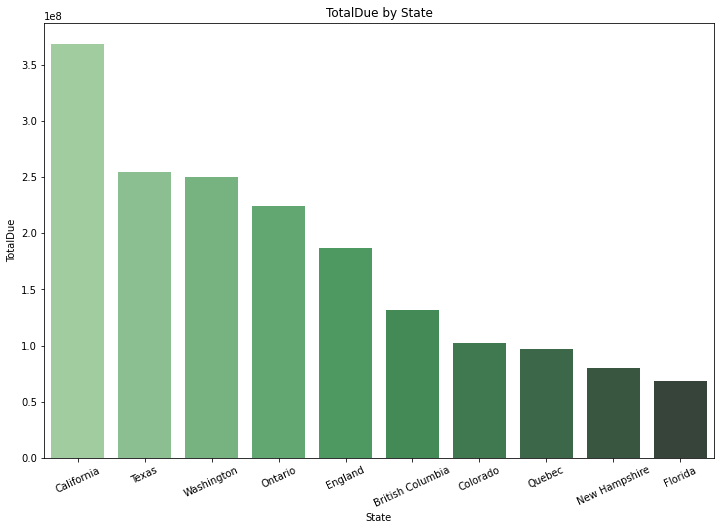

In [26]:
# Now we're plotting top10states in a Seaborn barplot
plt.figure(figsize=(12,8))
ax = sns.barplot(
    data = top10states, 
    x = top10states.index, 
    y = 'TotalDue',
    palette= 'Greens_d'
    ).set_title('TotalDue by State')
plt.xticks(rotation=25);

### 3. Exporting dataframes

In [27]:
# 3.0 -- Our dataframe is now ready for export
custdf.to_csv(path_or_buf= 'C:\\Users\\Bruen\\Dropbox\\My PC (DESKTOP-V41C1LD)\\Desktop\\AdventureWorksCustDF.csv')